# Redspots Environment

## Environment Description

A simple gridworld with white (safe) spots, green (rewarding) spots, and red (undesirable/dangerous) spots.

## Goal

Have an agent map the environment and infer the best way to avoid red spots and get to the green spot.

# Setup

## Imports

In [69]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cm as cm

import seaborn as sns

import pymdp
from pymdp import utils

## Auxilary Functions

In [70]:
def plot_grid(grid_locations, num_x = 3, num_y = 3 ):
    """
    Plots the spatial coordinates of GridWorld as a heatmap, with each (X, Y) coordinate 
    labeled with its linear index (its `state id`)
    """

    grid_heatmap = np.zeros((num_x, num_y))
    for linear_idx, location in enumerate(grid_locations):
      y, x = location
      grid_heatmap[y, x] = linear_idx
    sns.set(font_scale=1.5)
    sns.heatmap(grid_heatmap, annot=True, cbar = False, fmt='.0f', cmap='crest')

def plot_likelihood(matrix, title_str = "Likelihood distribution (A)"):
    """
    Plots a 2-D likelihood matrix as a heatmap
    """

    if not np.isclose(matrix.sum(axis=0), 1.0).all():
      raise ValueError("Distribution not column-normalized! Please normalize (ensure matrix.sum(axis=0) == 1.0 for all columns)")
    
    fig = plt.figure(figsize = (6,6))
    ax = sns.heatmap(matrix, cmap = 'gray', cbar = False, vmin = 0.0, vmax = 1.0)
    plt.title(title_str)
    plt.show()


def plot_beliefs(belief_dist, title_str=""):
    """
    Plot a categorical distribution or belief distribution, stored in the 1-D numpy vector `belief_dist`
    """

    if not np.isclose(belief_dist.sum(), 1.0):
      raise ValueError("Distribution not normalized! Please normalize")

    plt.grid(zorder=0)
    plt.bar(range(belief_dist.shape[0]), belief_dist, color='r', zorder=3)
    plt.xticks(range(belief_dist.shape[0]))
    plt.title(title_str)
    plt.show()

def add_noise(matrix, noise_level=0.1):
    """
    Add noise to transition matrix while preserving normalization
    
    Args:
        A: Original transition matrix
        noise_level: Amount of noise to add (0-1)
    """
    # Generate random noise
    noise = np.random.uniform(-noise_level, noise_level, size=matrix.shape)

    print(noise) 
    
    # Add noise to matrix
    noisy_matrix = matrix + noise
    
    # Ensure non-negative
    noisy_matrix = np.maximum(noisy_matrix, 0.0)
    
    # Normalize columns to sum to 1
    noisy_matrix = noisy_matrix / noisy_matrix.sum(axis=0, keepdims=True)
    
    return noisy_matrix

def move_to_grid(x, y, z):
    '''Moves coppelia coordinates (x,y,z) to a 200x200 grid, z coordinate remains constant, outputs coordinate in terms of grid'''
    
    # Translate x,y coordinate 2.5 up and 2.5 right
    x = x + 2.5
    y = y + 2.5
    
    # Ensure coordinates (x,y) are within (0,0) and (5,5)
    if x > 5 or x < 0:
        return "Invalid x coordinate!"
    elif y > 5 or y < 0:
        return "Invalid y coordinate!"
    
    # Convert x, y to grid indices by dividing by 0.05 (since each grid cell is 0.05 wide)
    x_grid = round(x / 0.05)
    y_grid = round(y / 0.05)
    
    # Ensure that the coordinates are within valid grid range (0 to 200)
    if x_grid > 200 or x_grid < 0:
        return "Invalid x grid point!"
    if y_grid > 200 or y_grid < 0:
        return "Invalid y grid point!"
    
    # Return the grid indices
    return (x_grid, y_grid)

    
def grid_to_coordinates(x_grid, y_grid, z):
    '''Converts a valid 200x200 grid point back into coppelia (x,y,z) coordinates in the range (x,y) = (0,0)-(5,5), z remains constant'''
    
    # Ensure the grid points are within valid range (0 to 200)
    if x_grid > 200 or x_grid < 0:
        return "Invalid x grid point!"
    if y_grid > 200 or y_grid < 0:
        return "Invalid y grid point!"
    
    # Reverse the grid index conversion by multiplying by 0.05
    x = x_grid * 0.05
    y = y_grid * 0.05
    
    # Return the original (x, y, z) coordinates
    return (x, y, z)

## Parameters

### Grid

In [71]:
# grid_dimensions
grid_dims = [8,5]

# list of grid positiions
grid_locations = []
for i in range(grid_dims[0]):
    for j in range(grid_dims[1]):
        grid_locations.append((i,j))

In [72]:
redspots = [(1,2), (3,2), (4,4), (4,3), (6,1), (6,3)]

In [73]:
# start point
agent_pos = (0,0)

# end goal
goal_location = (6,4)

## Generative Model

### States & Observations

s1 = current location \
s2 = attribute of current location

o1 = observed current location \
o2 = color of current location

In [74]:
# s1 is already defined = grid_locations

# s2
current_attribute = ['SAFE', 'DANGER', 'REWARDING']

# list of # of possibillities for states
num_states = [len(grid_locations), len(current_attribute)] # location

In [75]:
# o1 is already defined = grid_locatioons

# o2
current_color = ['WHITE', 'RED', 'GREEN']

# list of # of possibilities for observations
num_obs = [len(grid_locations), len(current_color)]

# Generative Model

## Agent's Observation Matrix

In [76]:
obs_matrix = np.zeros((num_states[0], num_states[1]))

# Rule-based assignment
for loc in range(num_states[0]):
    # Example: Assume all locations have [SAFE: 0.7, DANGER: 0.2, REWARDING: 0.1]
    obs_matrix[loc] = np.array([0.33, 0.33, 0.33])
    obs_matrix[loc] /= obs_matrix[loc].sum()

    # Normalize each location's attribute distribution (ensure sum = 1)

obs_matrix

array([[0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.

In [77]:
def update_obs_matrix(obs_matrix, obs):
    """
    Update the observation matrix based on an observation
    """

    one_hot_obs = [0,0,0]
    one_hot_obs[obs[1]] = 1
    obs_matrix[obs[0]] = one_hot_obs

    return obs_matrix

In [78]:
def visualize_obs_matrix(obs_matrix, grid_dims=grid_dims):
    """
    Visualizes the observation matrix as three separate heatmaps, one for each attribute
    (SAFE, DANGER, REWARDING)
    
    Args:
        obs_matrix: numpy array of shape (num_locations, num_attributes)
        grid_dims: list of [height, width] of the grid
    """
    # Create figure with three subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Labels for each subplot
    titles = ['SAFE', 'DANGER', 'REWARDING']
    
    for idx, title in enumerate(titles):
        # Reshape the matrix to match grid dimensions
        heatmap_data = obs_matrix[:, idx].reshape(grid_dims[0], grid_dims[1])
        
        # Plot heatmap
        sns.heatmap(heatmap_data, 
                   ax=axes[idx], 
                   cmap='YlOrRd',
                   vmin=0, 
                   vmax=1,
                   annot=True,
                   fmt='.2f')
        
        axes[idx].set_title(f'{title} Probability')
        axes[idx].set_xlabel('Y coordinate')
        axes[idx].set_ylabel('X coordinate')
    
    plt.tight_layout()
    plt.show()

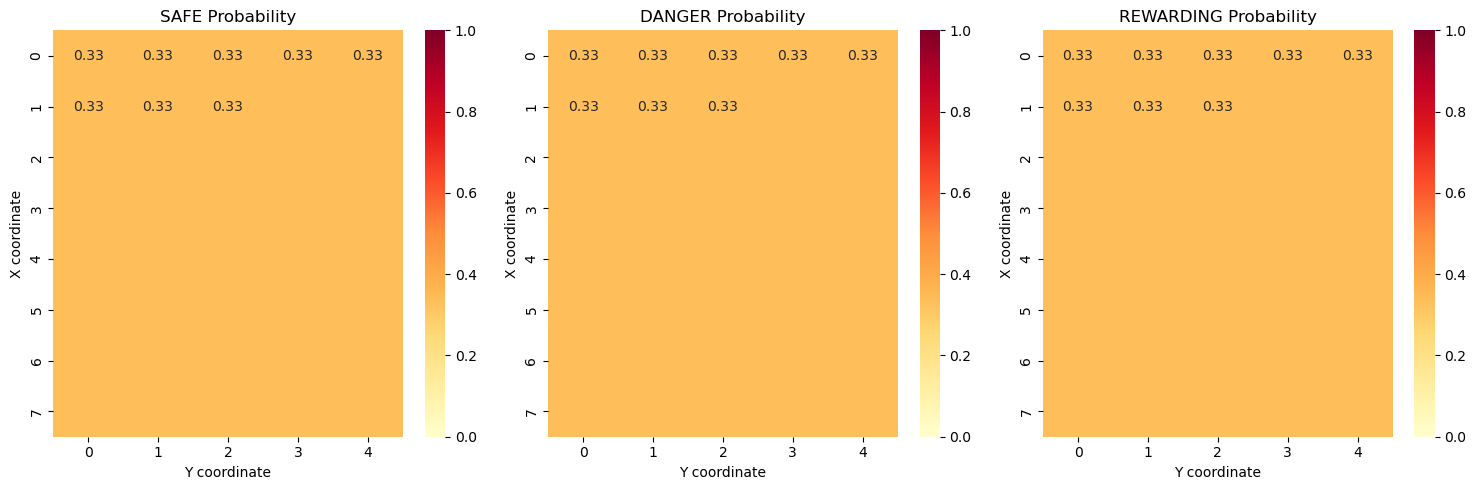

In [79]:
visualize_obs_matrix(obs_matrix, grid_dims)

## A Matrix

In [80]:
# Define A Matrix
A_shapes = []
for i in num_obs:
    A_shapes.append([i] + num_states)

A = utils.obj_array_zeros(A_shapes)
A.shape, A_shapes

((2,), [[40, 40, 3], [3, 40, 3]])

### Location Observation Modality A[0]

In [81]:
A[0] = np.zeros(A_shapes[0])  # Initialize with zeros

# Fill in the observation mapping for each safety level
for safety_level in range(num_states[1]):
    A[0][:,:,safety_level] = np.eye(num_states[0])  # Copy the identity matrix for each safety level

# Verify the shape and normalization
print("New A[0] shape:", A[0].shape)
print("Column sums:", A[0].sum(axis=0).sum(axis=1))  # Should be all 1's

New A[0] shape: (40, 40, 3)
Column sums: [3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]


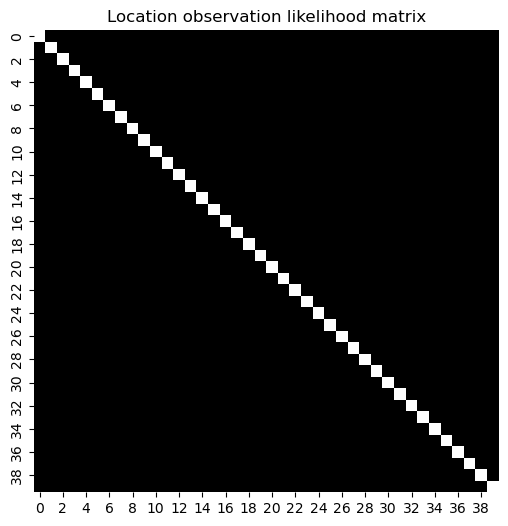

In [82]:
# Extract a 2D slice by fixing the safety level dimension to 0
import numpy as np
plot_likelihood(A[0][:, :, 0], "Location observation likelihood matrix")

### Color observation modality: A[1]

In [83]:
# Map safety levels to indices
safety_level_to_index = {state: i for i, state in enumerate(current_attribute)}  # {'SAFE': 0, 'DANGER': 1, 'REWARDING': 2}

# Probabilities for each color given the safety level (in correct heatmap order: RED, GREEN, WHITE)
probabilities = {
    "SAFE": [1, 0, 0],        # ['WHITE', 'RED', 'GREEN']
    "DANGER": [0, 1, 0.],      # ['WHITE', 'RED', 'GREEN']
    "REWARDING": [0, 0, 1]    # ['WHITE', 'RED', 'GREEN']
}

In [84]:
# Populate A[1]
for safety_level, probs in probabilities.items():
    safety_idx = safety_level_to_index[safety_level]
    for loc in range(len(grid_locations)):  # Iterate over grid locations
        for color_idx, prob in enumerate(probs):  # Iterate over colors (RED, GREEN, WHITE)
            A[1][color_idx, loc, safety_idx] = prob  # Assign probabilities

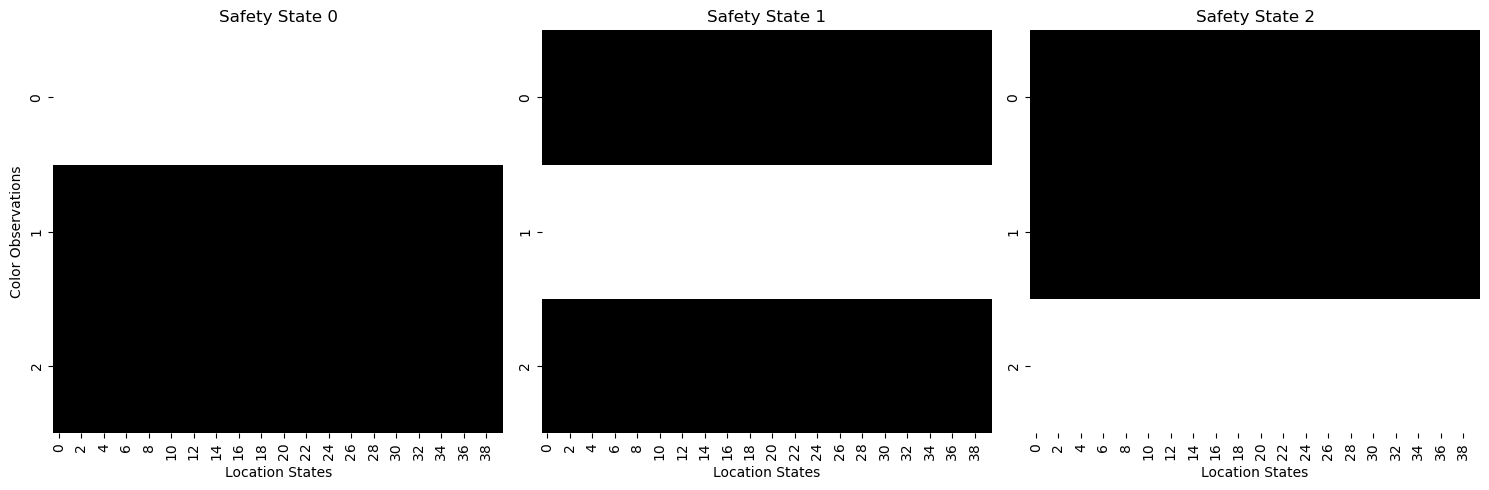

In [85]:
# Create a figure with 3 subplots (one for each safety state)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Extract and plot each safety state slice
for safety_idx in range(3):
    # Get a slice for the current safety state (fixing all other dimensions to 0)
    slice_matrix = A[1][:, :, safety_idx]
    
    # Plot the slice
    sns.heatmap(slice_matrix, ax=axes[safety_idx], cmap='gray', cbar=False, vmin=0.0, vmax=1.0)
    axes[safety_idx].set_title(f'Safety State {safety_idx}')
    axes[safety_idx].set_xlabel('Location States')
    if safety_idx == 0:
        axes[safety_idx].set_ylabel('Color Observations')

plt.tight_layout()
plt.show()

### Add Noise

In [86]:
# Add noise to each modality separately
for modality in range(len(A)):
    A[modality] = add_noise(A[modality], noise_level=0)

[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0

### Plot Each Matrix

## B Matrix

### Define Shape

In [87]:
num_controls = [5, 1]
B_f_shapes = [ [ns, ns, num_controls[f]] for f, ns in enumerate(num_states)]
B = utils.obj_array_zeros(B_f_shapes)
B_f_shapes

[[40, 40, 5], [3, 3, 1]]

### B[0] - Control Factor - Location Transitions

In [88]:
grid_dims

[8, 5]

In [89]:
actions = ["UP", "DOWN", "LEFT", "RIGHT", "STAY"]

In [90]:
for action_id, action_label in enumerate(actions):
  
    for curr_state, (x, y) in enumerate(grid_locations):
        
        # Calculate next position based on action
        if action_label == "UP":
            next_y = max(0, y - 1)        # Move up (decrease y)
            next_x = x
        elif action_label == "DOWN":
            next_y = min(grid_dims[1]-1, y + 1)  # Move down (increase y)
            next_x = x
        elif action_label == "LEFT":
            next_x = max(0, x - 1)        # Move left (decrease x)
            next_y = y
        elif action_label == "RIGHT":
            next_x = min(grid_dims[0]-1, x + 1)  # Move right (increase x)
            next_y = y
        else:  # STAY
            next_x = x
            next_y = y
        
        # Get the state index for the next position
        next_state = grid_locations.index((next_x, next_y))
        
        # Set transition probability to 1.0
        B[0][next_state, curr_state, action_id] = 1.0

### B[1] - Non-Control Factor - Identity Matrix

In [91]:
# Initialize safety level transition matrix (no changes for safety levels)
B[1][:,:,0] = np.eye(3)  # Identity matrix for safety level transitions

### Normalization

In [92]:
# Normalize B matrix columns for each action
for action_id in range(len(actions)):
    # Get slice for current action
    B_action = B[0][..., action_id]
    
    # Replace zero columns with ones in appropriate positions
    zero_cols = (B_action.sum(axis=0) == 0)
    for col in range(B_action.shape[1]):
        if zero_cols[col]:
            # Stay in the same state if no transition is defined
            B_action[col, col] = 1.0
    
    # Normalize columns
    column_sums = B_action.sum(axis=0)
    B[0][..., action_id] = B_action / column_sums[None, :]

# Verify normalization
for action_id in range(len(actions)):
    assert np.allclose(B[0][..., action_id].sum(axis=0), 1.0), f"Action {actions[action_id]} not normalized"

In [93]:
print(B[1])

[[[1.]
  [0.]
  [0.]]

 [[0.]
  [1.]
  [0.]]

 [[0.]
  [0.]
  [1.]]]


## C Vectors (prior preferences)

### Initialize

In [94]:
C = utils.obj_array_zeros(num_obs)  # Initialize C array with shape matching num_obs
print(C.shape)

(2,)


### C[0] - Preference for location observations

In [95]:
goal_location

(6, 4)

In [96]:
# Set preferences for state observations (location)
C[0] = np.ones(len(grid_locations))
C[0][grid_locations.index(goal_location)] += 1

print(C[0])

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1.]


In [97]:
for i, loc in enumerate(grid_locations):
    x = ((goal_location[0] - loc[0])**2 + (goal_location[1] - loc[1])**2) ** 0.5
    print(loc, i, x)
    C[0][i] -= x * 0.1

(0, 0) 0 7.211102550927978
(0, 1) 1 6.708203932499369
(0, 2) 2 6.324555320336759
(0, 3) 3 6.082762530298219
(0, 4) 4 6.0
(1, 0) 5 6.4031242374328485
(1, 1) 6 5.830951894845301
(1, 2) 7 5.385164807134504
(1, 3) 8 5.0990195135927845
(1, 4) 9 5.0
(2, 0) 10 5.656854249492381
(2, 1) 11 5.0
(2, 2) 12 4.47213595499958
(2, 3) 13 4.123105625617661
(2, 4) 14 4.0
(3, 0) 15 5.0
(3, 1) 16 4.242640687119285
(3, 2) 17 3.605551275463989
(3, 3) 18 3.1622776601683795
(3, 4) 19 3.0
(4, 0) 20 4.47213595499958
(4, 1) 21 3.605551275463989
(4, 2) 22 2.8284271247461903
(4, 3) 23 2.23606797749979
(4, 4) 24 2.0
(5, 0) 25 4.123105625617661
(5, 1) 26 3.1622776601683795
(5, 2) 27 2.23606797749979
(5, 3) 28 1.4142135623730951
(5, 4) 29 1.0
(6, 0) 30 4.0
(6, 1) 31 3.0
(6, 2) 32 2.0
(6, 3) 33 1.0
(6, 4) 34 0.0
(7, 0) 35 4.123105625617661
(7, 1) 36 3.1622776601683795
(7, 2) 37 2.23606797749979
(7, 3) 38 1.4142135623730951
(7, 4) 39 1.0


In [98]:
print(C[0])

[0.27888974 0.32917961 0.36754447 0.39172375 0.4        0.35968758
 0.41690481 0.46148352 0.49009805 0.5        0.43431458 0.5
 0.5527864  0.58768944 0.6        0.5        0.57573593 0.63944487
 0.68377223 0.7        0.5527864  0.63944487 0.71715729 0.7763932
 0.8        0.58768944 0.68377223 0.7763932  0.85857864 0.9
 0.6        0.7        0.8        0.9        2.         0.58768944
 0.68377223 0.7763932  0.85857864 0.9       ]


In [99]:
from pymdp.maths import softmax

In [100]:
C[0] = softmax(C[0])

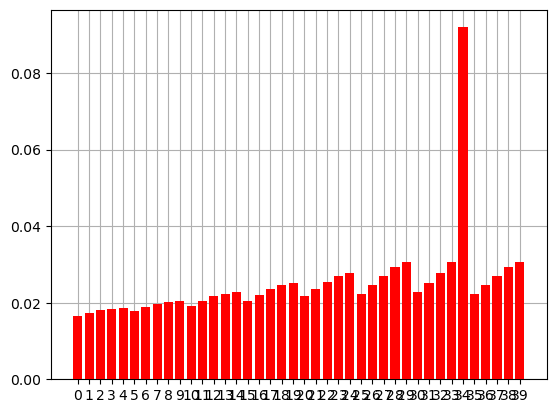

In [101]:
plot_beliefs(C[0])

### C[1] - Preference for color observations

In [102]:
# white, red, green <- order it's encoded in

In [103]:
# Set preferences for color observations
C[1] = np.zeros((num_obs[1],))
C[1][0] = -0.1
C[1][1] = -1
C[1][2] = 1.1

print(C[1])


[-0.1 -1.   1.1]


## D Vectors: Prior beliefs about hidden states

### Initialize

In [104]:
# Shape
num_states

[40, 3]

In [105]:
D = utils.obj_array_uniform(num_states)

### D[0] - Belief About Current Location

In [106]:
# Define prior belief about agent's location (same as before)
D[0] = np.zeros(num_states[0])  # Shape (35,)
D[0][grid_locations.index(agent_pos)] = 1.0  # One-hot encoding for location

print("D[0] shape (Location prior):", D[0].shape)  # (35,)
D[0]

D[0] shape (Location prior): (40,)


array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.])

In [107]:
# # Initialize uniform distribution over locations
# D[0] = np.ones(num_states[0]) / num_states[0]  # Create normalized uniform distribution over all locations

# D[0]

### D[1] - Belief About Attribute of Current Location

In [108]:
D[1] = np.ones(num_states[1]) / num_states[1]  # Create normalized uniform distribution over all locations
D[1].shape

(3,)

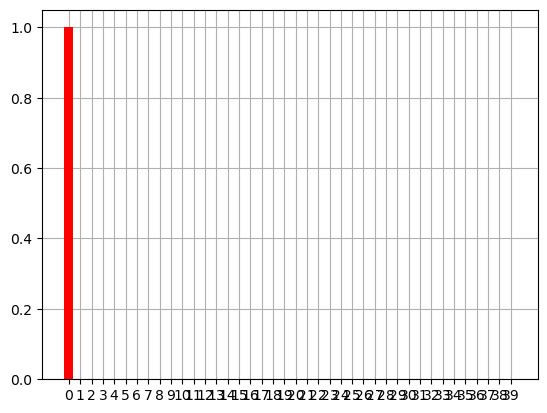

In [109]:
plot_beliefs(D[0])

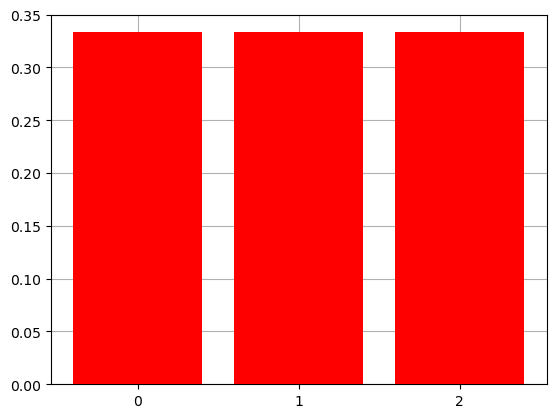

In [110]:
plot_beliefs(D[1])

# Generative Process

In [111]:
def update_vision(current_location, grid_dims, distance):
    """
    Update the agent's field of vision based on the current location and distance
    Returns a list of all grid positions within the vision range
    
    Args:
        current_location (tuple): Current (x,y) position of the agent
        grid_dims (list): Dimensions of the grid [width, height]
        distance (int): Vision range/distance
        
    Returns:
        list: List of (x,y) tuples representing visible grid positions
    """
    x, y = current_location
    x_min = max(0, x - distance)
    x_max = min(grid_dims[0], x + distance + 1)
    y_min = max(0, y - distance)
    y_max = min(grid_dims[1], y + distance + 1)
    
    visible_locations = []
    for y_pos in range(y_min, y_max):
        for x_pos in range(x_min, x_max):
            visible_locations.append((x_pos, y_pos))
            
    return visible_locations

In [112]:
X, Y = 0, 0

In [113]:
class GridWorldEnv():
    def __init__(self, starting_loc=(0, 0), redspots=[(1, 2), (3, 2), (4, 4), (6, 1)], goal=(6,4)):
        # Initialize coordinates
        self.x, self.y = starting_loc
        self.init_loc = starting_loc
        self.current_location = (self.x, self.y)

        self.goal = goal

        self.redspots = redspots

        self.red_obs = ['Null']
        self.green_obs = 'Null'
        self.white_obs = ['Null']

        self.agent_reward = 0
        
        print(f"Starting location is {self.current_location} | Red spot locations are {self.redspots} | Goal is {self.goal}")
    
    def step(self, action_label):
        if action_label == "UP": 
            self.y = max(0, self.y - 1)  # Move up (decrease y)
            
        elif action_label == "DOWN": 
            self.y = min(grid_dims[1] - 1, self.y + 1)  # Move down (increase y)

        elif action_label == "LEFT": 
            self.x = max(0, self.x - 1)  # Move left (decrease x)

        elif action_label == "RIGHT": 
            self.x = min(grid_dims[0] - 1, self.x + 1)  # Move right (increase x)

        # Update current_location tuple after movement
        self.current_location = (self.x, self.y)
        print(f"self.current_location: {self.current_location}")
        
        # Update vision with current coordinates
        self.vision = update_vision(self.current_location, grid_dims, 6)

        self.loc_obs = self.current_location

        # Reset observations at each step
        self.red_obs = ['Null']
        self.white_obs = ['Null']
        self.green_obs = 'Null'

        # Update observations based on vision
        for spot in self.vision:
            if spot in self.redspots:
                if 'Null' in self.red_obs:
                    self.red_obs = [spot]
                else:
                    self.red_obs.append(spot)
            elif spot == self.goal:
                self.green_obs = spot
            else:
                if 'Null' in self.white_obs:
                    self.white_obs = [spot]
                else:
                    self.white_obs.append(spot)

        # Update rewards and observations based on current location
        if self.current_location in self.redspots:
            self.agent_reward -= 5
            if 'Null' in self.red_obs:
                self.red_obs = [self.current_location]
            else:
                self.red_obs.append(self.current_location)
        elif self.current_location == self.goal:
            self.agent_reward += 20
            self.green_obs = self.current_location
        else:
            if 'Null' in self.white_obs:
                self.white_obs = [self.current_location]
            else:
                self.white_obs.append(self.current_location)
        
        return self.loc_obs, self.green_obs, self.white_obs, self.red_obs, self.agent_reward
    
    def reset(self):
        self.x, self.y = self.init_loc
        self.current_location = (self.x, self.y)
        print(f'Re-initialized location to {self.current_location}')
        self.loc_obs = self.current_location
        self.green_obs, self.white_obs, self.red_obs, self.agent_reward = 'Null', ['Null'], ['Null'], 0

        return self.loc_obs, self.green_obs, self.white_obs, self.red_obs, self.agent_reward

# Customizing Functions

In [114]:
from pymdp.maths import spm_dot 

def custom_get_expected_obs(qs_pi, A, obs_matrix=obs_matrix):
    n_steps = len(qs_pi) # each element of the list is the PPD at a different timestep

    # initialise expected observations
    qo_pi = []

    for t in range(n_steps):
        qo_pi_t = utils.obj_array(len(A))
        qo_pi.append(qo_pi_t)

    # compute expected observations over time
    for t in range(n_steps):
        for modality, A_m in enumerate(A):
            qo_pi[t][modality] = spm_dot(A_m, qs_pi[t])

    # apply expected color observations
    for t in range(len(qo_pi)):
        location_beliefs = qo_pi[t][0]  # Shape matches o1 dimension
        qo_pi[t][1] = np.array(obs_matrix[location_beliefs.argmax()])
        
        # Visualization for debugging
        # print(f"\nTimestep {t}:")
        # print("Location beliefs (qo_pi[t][0]):")
        # plot_beliefs(qo_pi[t][0], f"Expected Location Distribution - Step {t}")
        # print("\nColor beliefs (qo_pi[t][1]):")
        # plot_beliefs(qo_pi[t][1], f"Expected Color Distribution - Step {t}")
                
    return qo_pi

In [115]:
from pymdp import control

# Inject our custom function
control.get_expected_obs = custom_get_expected_obs

# Active Inference

In [116]:
from pymdp.agent import Agent

In [117]:
agent_pos, redspots, goal_location

((0, 0), [(1, 2), (3, 2), (4, 4), (4, 3), (6, 1), (6, 3)], (6, 4))

In [118]:
# Create base agent
my_agent = Agent(A=A, B=B, C=C, D=D, policy_len=3)

my_env = GridWorldEnv(starting_loc = agent_pos, redspots=redspots, goal = goal_location)

Starting location is (0, 0) | Red spot locations are [(1, 2), (3, 2), (4, 4), (4, 3), (6, 1), (6, 3)] | Goal is (6, 4)


In [119]:
loc_obs, green_obs, white_obs, red_obs, agent_reward = my_env.reset()
loc_obs, green_obs, white_obs, red_obs, agent_reward

Re-initialized location to (0, 0)


((0, 0), 'Null', ['Null'], ['Null'], 0)

In [120]:
loc_obs, green_obs, white_obs, red_obs, agent_reward = my_env.step('STAY')

self.current_location: (0, 0)


In [121]:
loc_obs, green_obs, white_obs, red_obs, agent_reward

((0, 0),
 (6, 4),
 [(0, 0),
  (1, 0),
  (2, 0),
  (3, 0),
  (4, 0),
  (5, 0),
  (6, 0),
  (0, 1),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 1),
  (0, 2),
  (2, 2),
  (4, 2),
  (5, 2),
  (6, 2),
  (0, 3),
  (1, 3),
  (2, 3),
  (3, 3),
  (5, 3),
  (0, 4),
  (1, 4),
  (2, 4),
  (3, 4),
  (5, 4),
  (0, 0)],
 [(6, 1), (1, 2), (3, 2), (4, 3), (6, 3), (4, 4)],
 0)

## Create Observation

In [122]:
loc_obs

(0, 0)

In [123]:
grid_locations

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (1, 4),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (2, 4),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 3),
 (3, 4),
 (4, 0),
 (4, 1),
 (4, 2),
 (4, 3),
 (4, 4),
 (5, 0),
 (5, 1),
 (5, 2),
 (5, 3),
 (5, 4),
 (6, 0),
 (6, 1),
 (6, 2),
 (6, 3),
 (6, 4),
 (7, 0),
 (7, 1),
 (7, 2),
 (7, 3),
 (7, 4)]

In [124]:
def create_color_observation(position, red_obs, green_obs, white_obs):

    if red_obs != ['Null']:
        if position in red_obs: return 1  # RED
    if green_obs == position: return 2 # GREEN
    elif white_obs != ['Null']:
        if position in white_obs: return 0 # WHITE
    return 3

In [125]:
def create_observation(position, red_obs, green_obs, white_obs):
    return [grid_locations.index(position), create_color_observation(position, red_obs, green_obs, white_obs)]

## Loop

Observation: [0, 0]


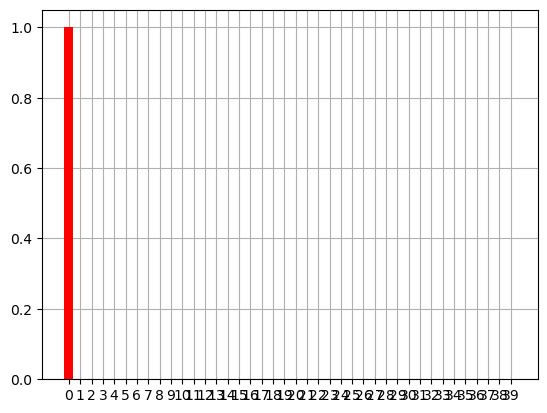

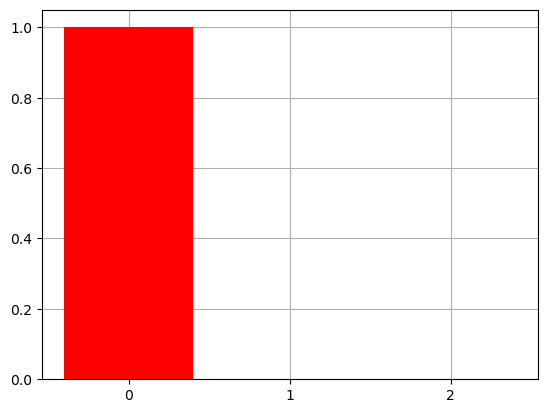

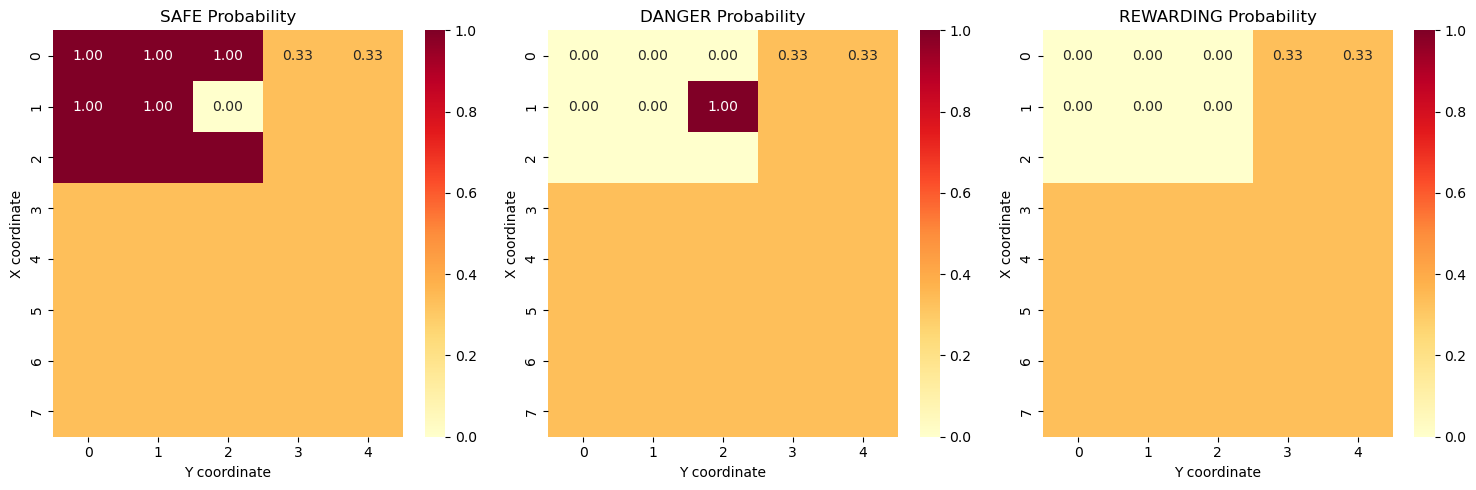

Action at time 0: RIGHT
self.current_location: (1, 0)
0 (1, 0) (6, 4) [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (7, 1), (0, 2), (2, 2), (4, 2), (5, 2), (6, 2), (7, 2), (0, 3), (1, 3), (2, 3), (3, 3), (5, 3), (7, 3), (0, 4), (1, 4), (2, 4), (3, 4), (5, 4), (7, 4), (1, 0)] [(6, 1), (1, 2), (3, 2), (4, 3), (6, 3), (4, 4)]
Grid location at time 0: (1, 0)
Reward at time 0: 0
Observation: [5, 0]


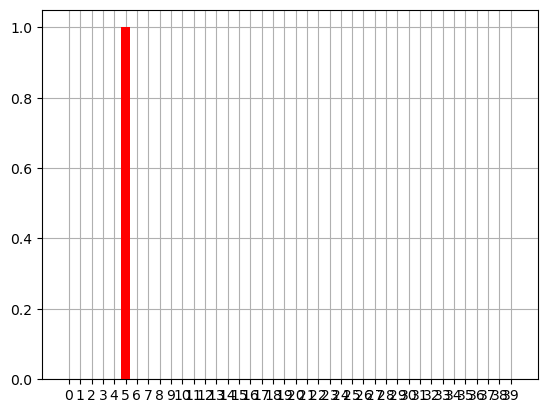

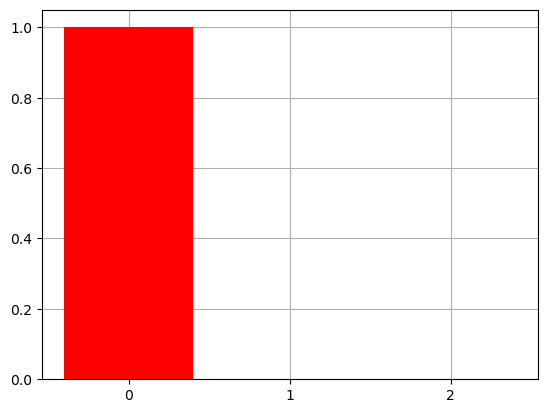

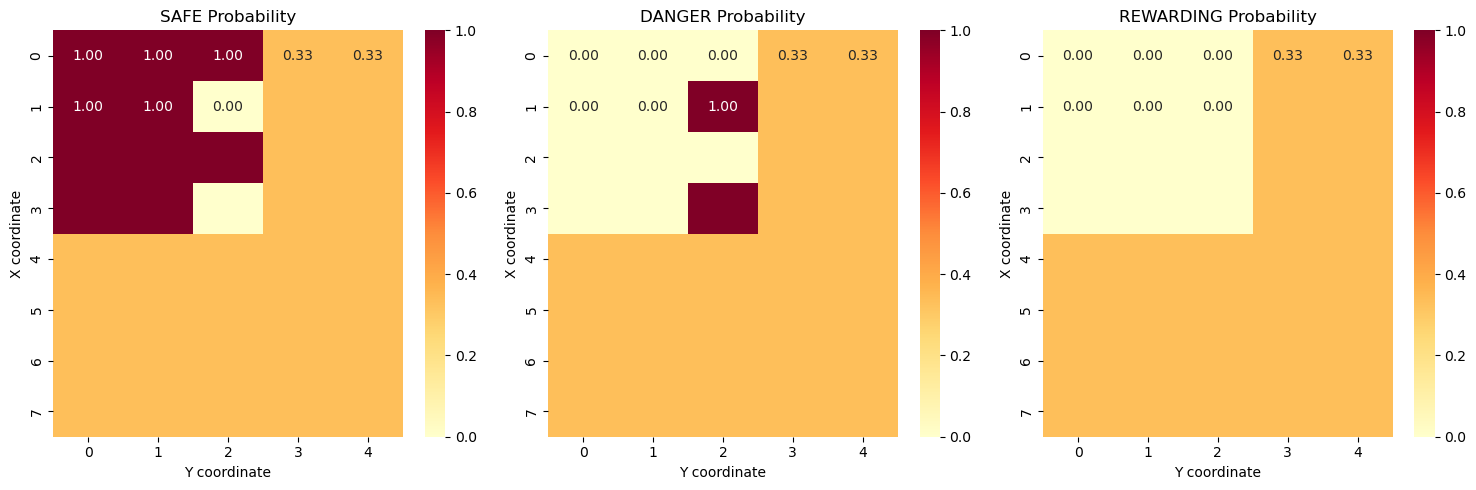

Action at time 1: RIGHT
self.current_location: (2, 0)
0 (2, 0) (6, 4) [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (7, 1), (0, 2), (2, 2), (4, 2), (5, 2), (6, 2), (7, 2), (0, 3), (1, 3), (2, 3), (3, 3), (5, 3), (7, 3), (0, 4), (1, 4), (2, 4), (3, 4), (5, 4), (7, 4), (2, 0)] [(6, 1), (1, 2), (3, 2), (4, 3), (6, 3), (4, 4)]
Grid location at time 1: (2, 0)
Reward at time 1: 0
Observation: [10, 0]


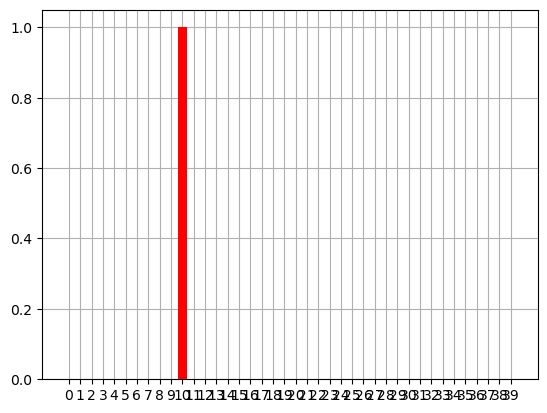

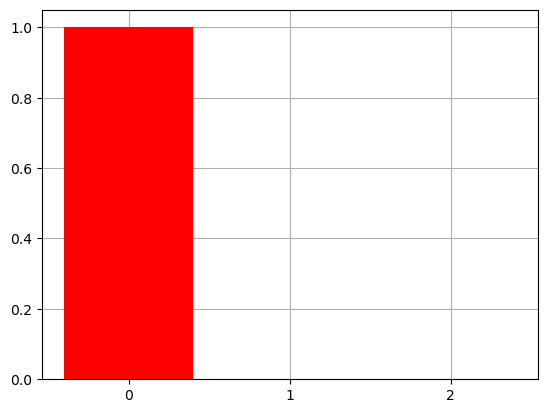

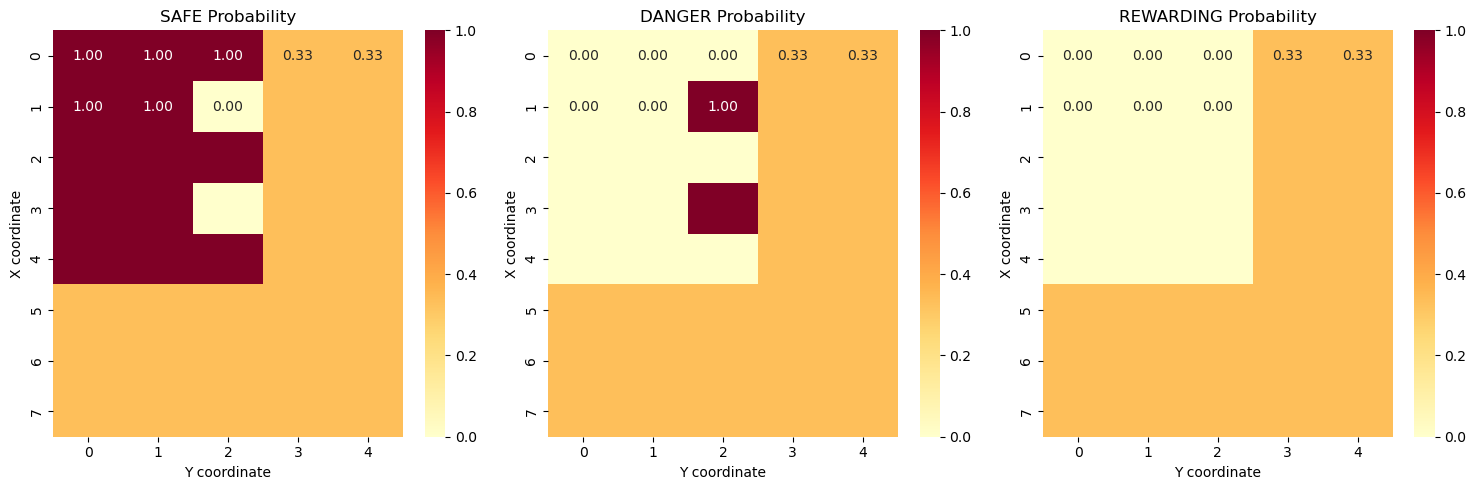

Action at time 2: RIGHT
self.current_location: (3, 0)
0 (3, 0) (6, 4) [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (7, 1), (0, 2), (2, 2), (4, 2), (5, 2), (6, 2), (7, 2), (0, 3), (1, 3), (2, 3), (3, 3), (5, 3), (7, 3), (0, 4), (1, 4), (2, 4), (3, 4), (5, 4), (7, 4), (3, 0)] [(6, 1), (1, 2), (3, 2), (4, 3), (6, 3), (4, 4)]
Grid location at time 2: (3, 0)
Reward at time 2: 0
Observation: [15, 0]


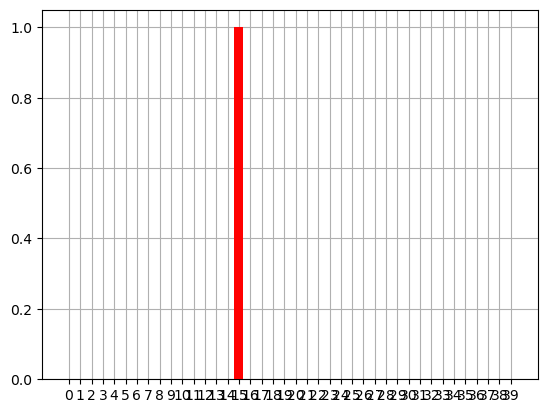

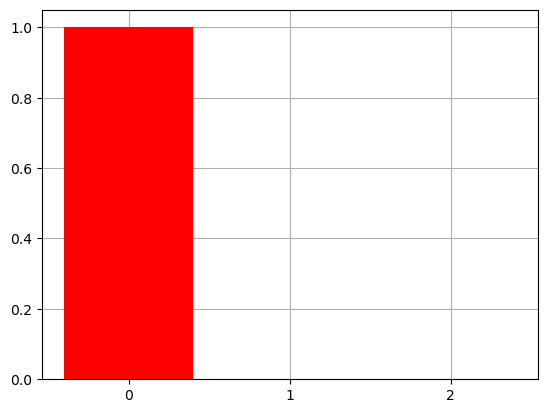

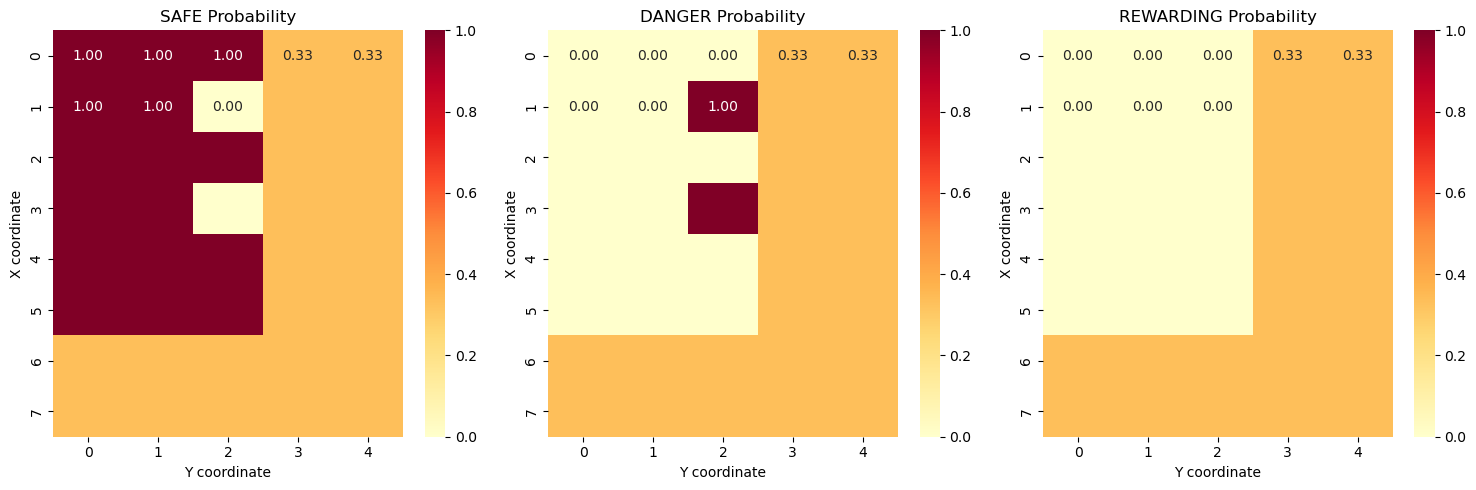

Action at time 3: RIGHT
self.current_location: (4, 0)
0 (4, 0) (6, 4) [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (7, 1), (0, 2), (2, 2), (4, 2), (5, 2), (6, 2), (7, 2), (0, 3), (1, 3), (2, 3), (3, 3), (5, 3), (7, 3), (0, 4), (1, 4), (2, 4), (3, 4), (5, 4), (7, 4), (4, 0)] [(6, 1), (1, 2), (3, 2), (4, 3), (6, 3), (4, 4)]
Grid location at time 3: (4, 0)
Reward at time 3: 0
Observation: [20, 0]


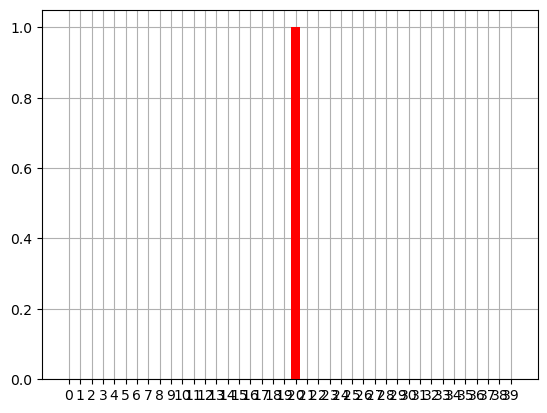

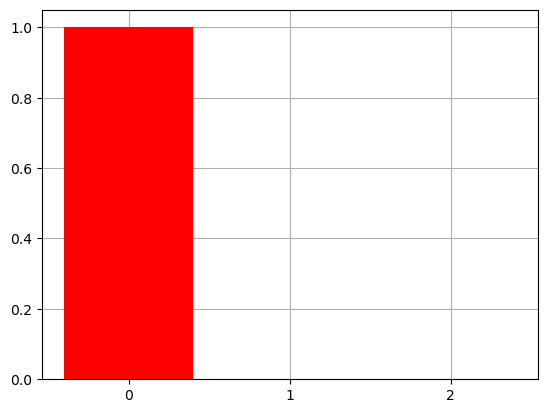

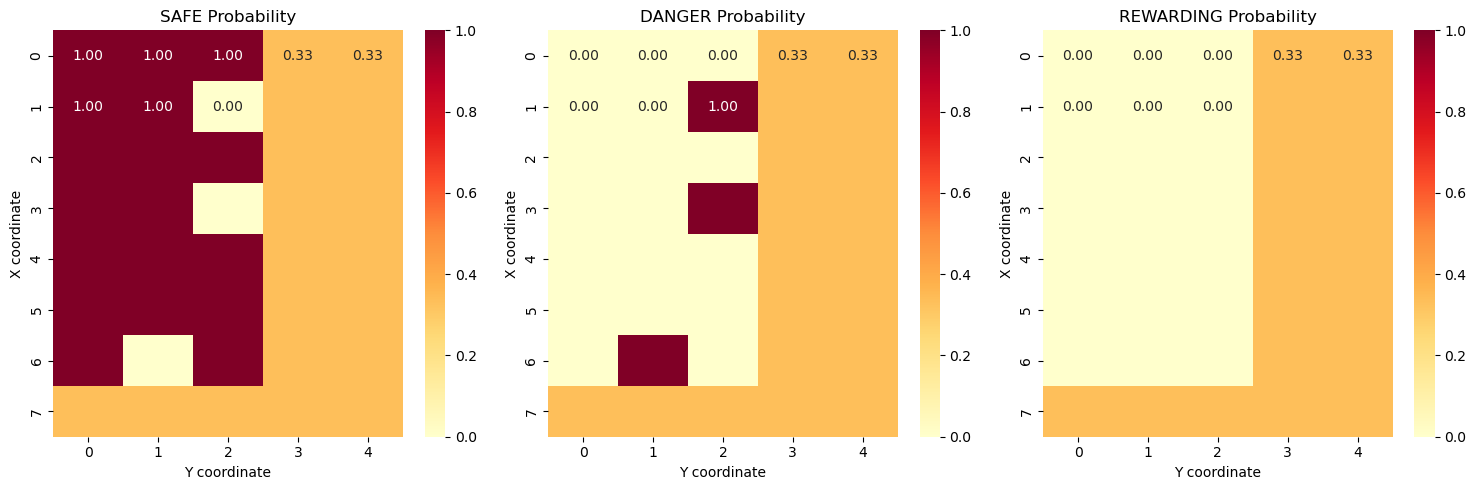

Action at time 4: DOWN
self.current_location: (4, 1)
0 (4, 1) (6, 4) [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (7, 1), (0, 2), (2, 2), (4, 2), (5, 2), (6, 2), (7, 2), (0, 3), (1, 3), (2, 3), (3, 3), (5, 3), (7, 3), (0, 4), (1, 4), (2, 4), (3, 4), (5, 4), (7, 4), (4, 1)] [(6, 1), (1, 2), (3, 2), (4, 3), (6, 3), (4, 4)]
Grid location at time 4: (4, 1)
Reward at time 4: 0
Observation: [21, 0]


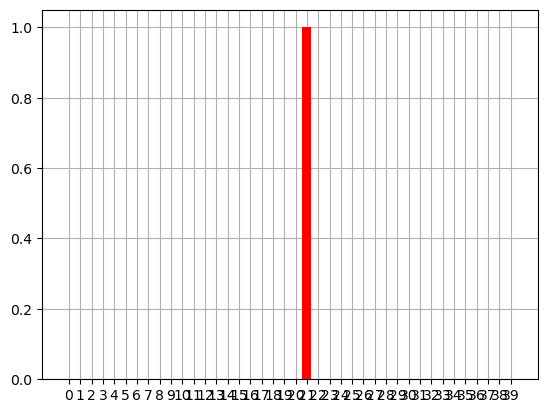

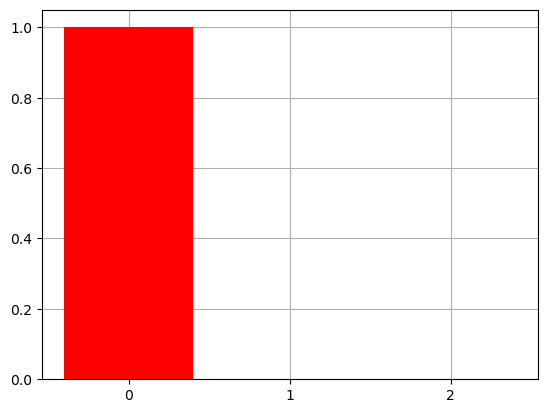

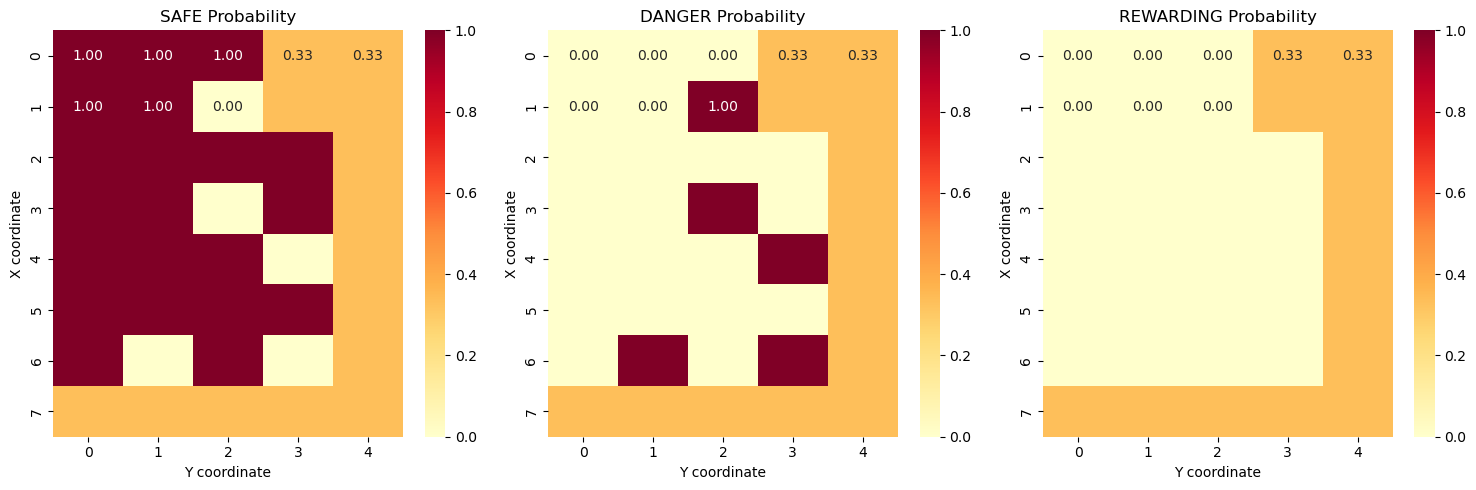

Action at time 5: UP
self.current_location: (4, 0)
0 (4, 0) (6, 4) [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (7, 1), (0, 2), (2, 2), (4, 2), (5, 2), (6, 2), (7, 2), (0, 3), (1, 3), (2, 3), (3, 3), (5, 3), (7, 3), (0, 4), (1, 4), (2, 4), (3, 4), (5, 4), (7, 4), (4, 0)] [(6, 1), (1, 2), (3, 2), (4, 3), (6, 3), (4, 4)]
Grid location at time 5: (4, 0)
Reward at time 5: 0
Observation: [20, 0]


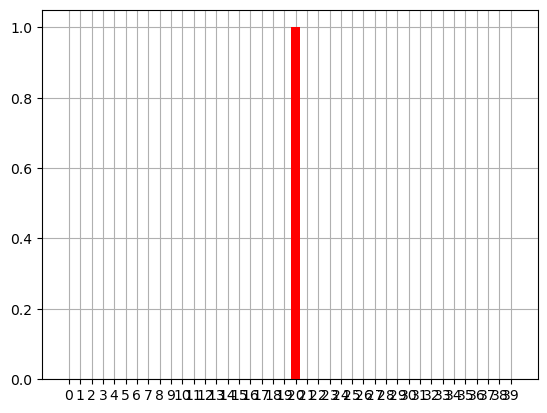

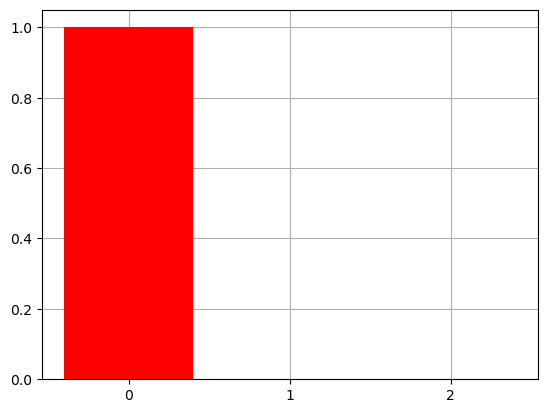

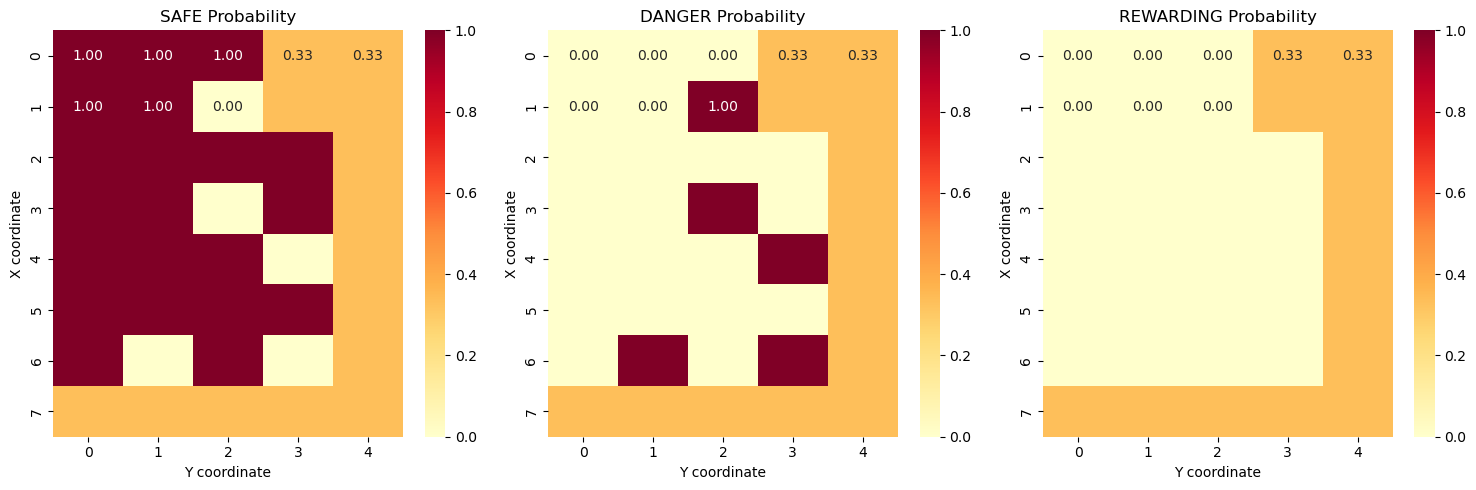

Action at time 6: RIGHT
self.current_location: (5, 0)
0 (5, 0) (6, 4) [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (7, 1), (0, 2), (2, 2), (4, 2), (5, 2), (6, 2), (7, 2), (0, 3), (1, 3), (2, 3), (3, 3), (5, 3), (7, 3), (0, 4), (1, 4), (2, 4), (3, 4), (5, 4), (7, 4), (5, 0)] [(6, 1), (1, 2), (3, 2), (4, 3), (6, 3), (4, 4)]
Grid location at time 6: (5, 0)
Reward at time 6: 0
Observation: [25, 0]


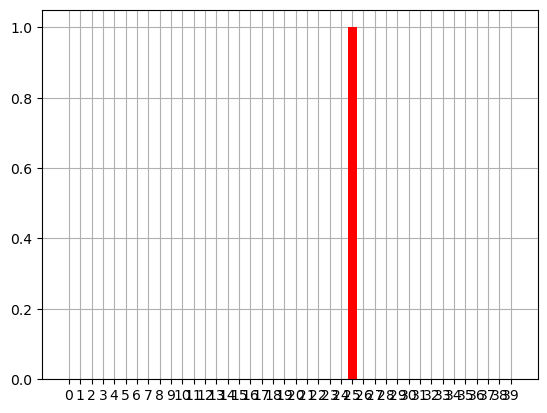

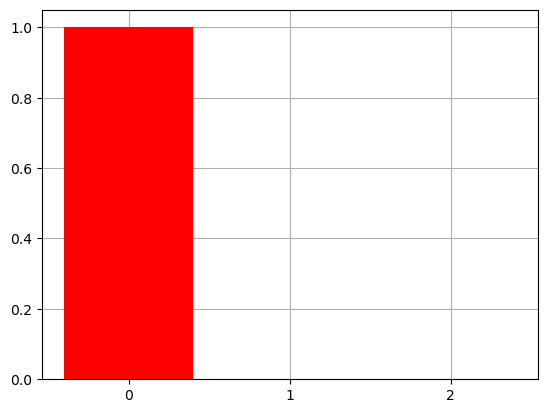

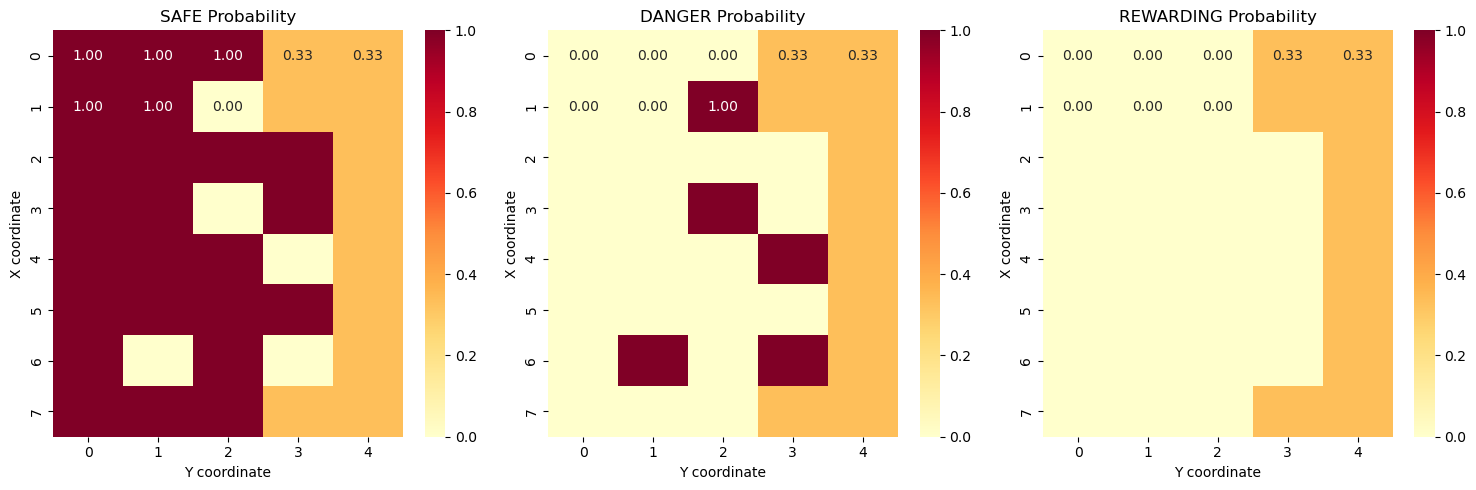

Action at time 7: LEFT
self.current_location: (4, 0)
0 (4, 0) (6, 4) [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (7, 1), (0, 2), (2, 2), (4, 2), (5, 2), (6, 2), (7, 2), (0, 3), (1, 3), (2, 3), (3, 3), (5, 3), (7, 3), (0, 4), (1, 4), (2, 4), (3, 4), (5, 4), (7, 4), (4, 0)] [(6, 1), (1, 2), (3, 2), (4, 3), (6, 3), (4, 4)]
Grid location at time 7: (4, 0)
Reward at time 7: 0
Observation: [20, 0]


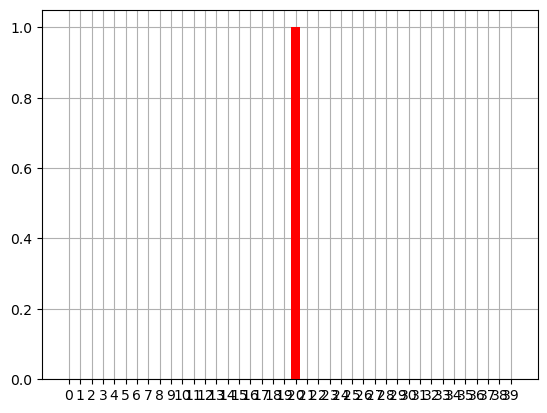

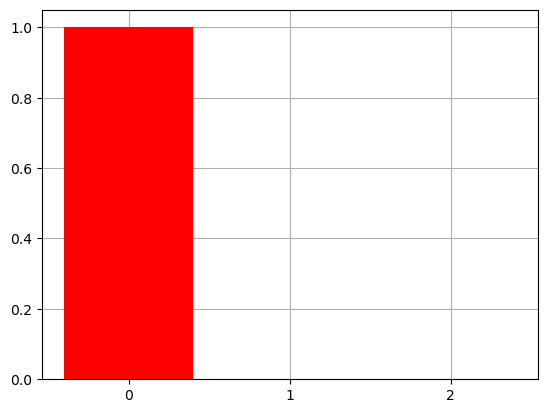

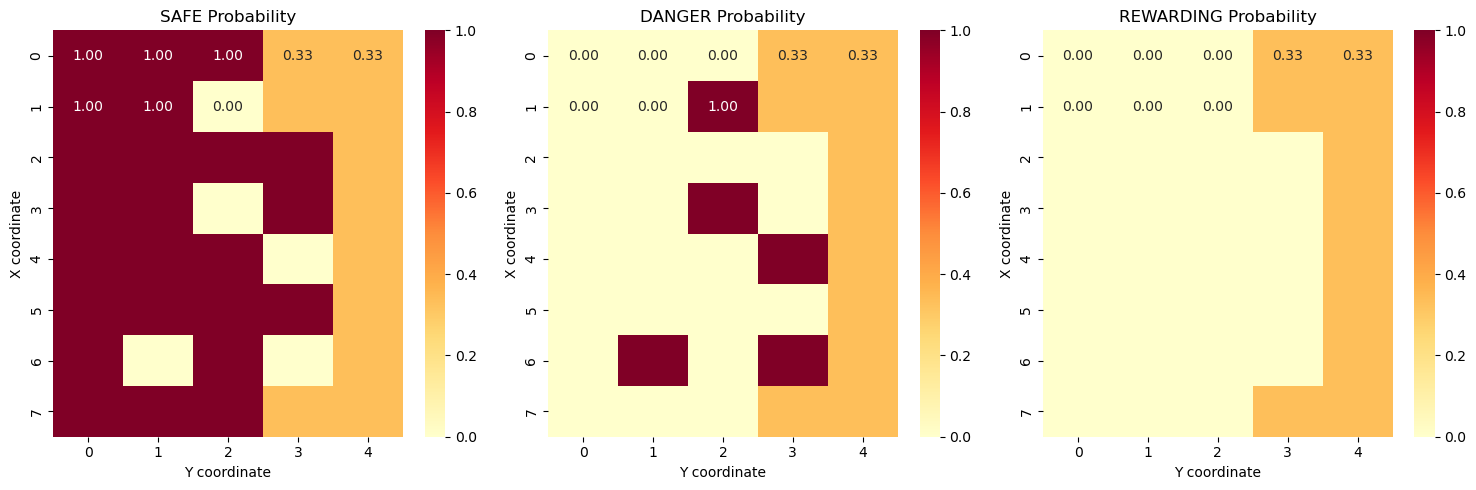

Action at time 8: UP
self.current_location: (4, 0)
0 (4, 0) (6, 4) [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (7, 1), (0, 2), (2, 2), (4, 2), (5, 2), (6, 2), (7, 2), (0, 3), (1, 3), (2, 3), (3, 3), (5, 3), (7, 3), (0, 4), (1, 4), (2, 4), (3, 4), (5, 4), (7, 4), (4, 0)] [(6, 1), (1, 2), (3, 2), (4, 3), (6, 3), (4, 4)]
Grid location at time 8: (4, 0)
Reward at time 8: 0
Observation: [20, 0]


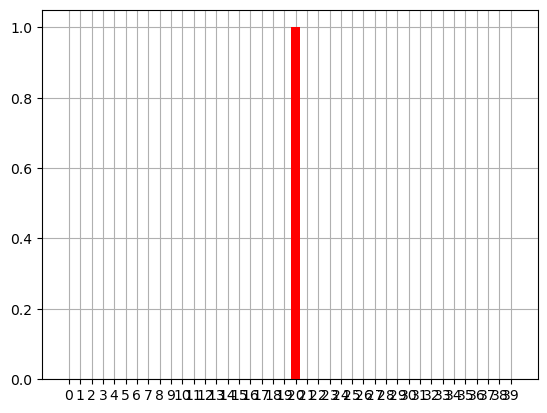

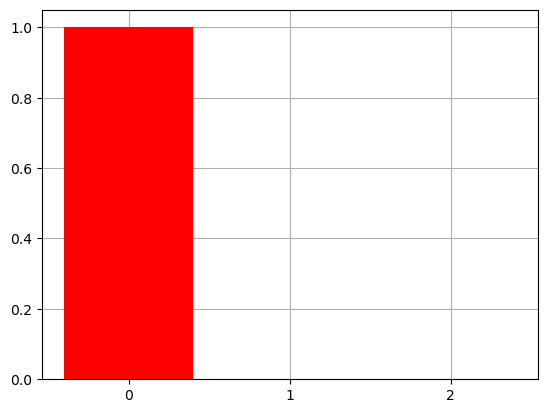

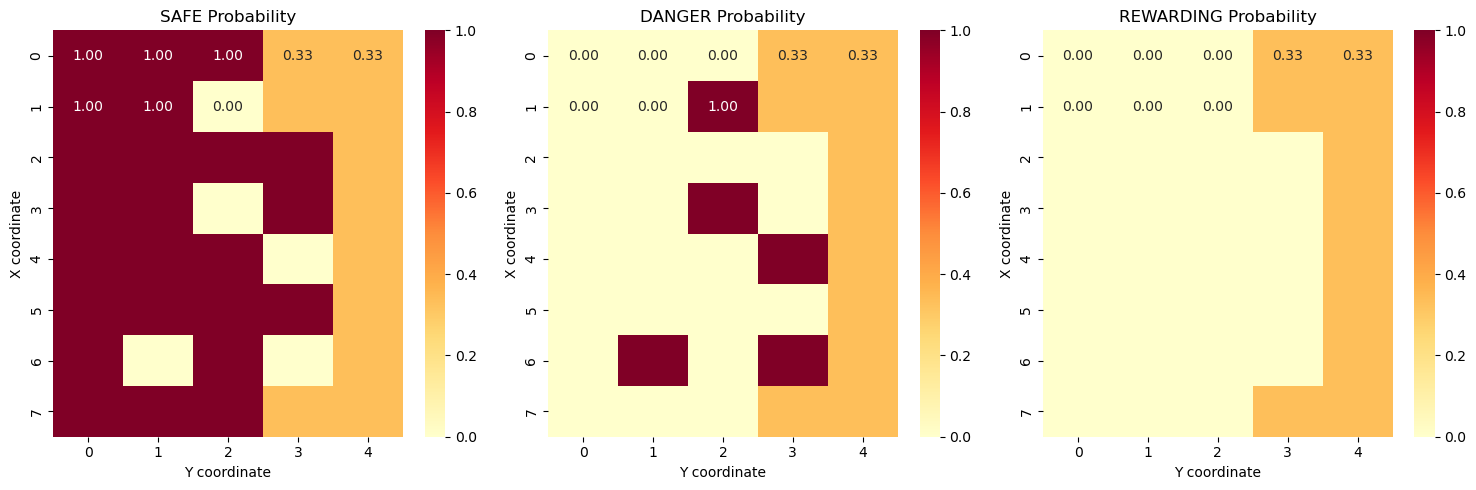

Action at time 9: UP
self.current_location: (4, 0)
0 (4, 0) (6, 4) [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (7, 1), (0, 2), (2, 2), (4, 2), (5, 2), (6, 2), (7, 2), (0, 3), (1, 3), (2, 3), (3, 3), (5, 3), (7, 3), (0, 4), (1, 4), (2, 4), (3, 4), (5, 4), (7, 4), (4, 0)] [(6, 1), (1, 2), (3, 2), (4, 3), (6, 3), (4, 4)]
Grid location at time 9: (4, 0)
Reward at time 9: 0
Observation: [20, 0]


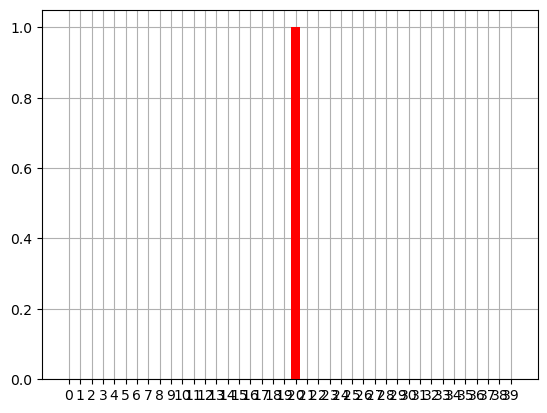

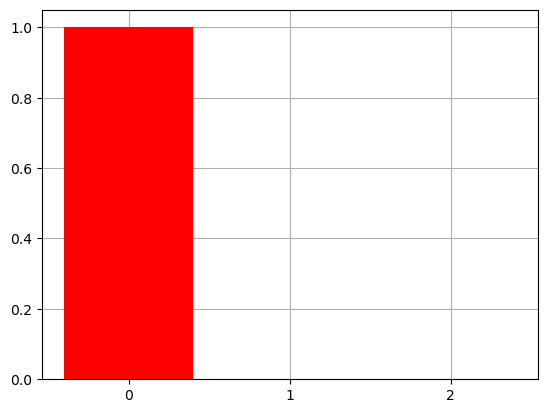

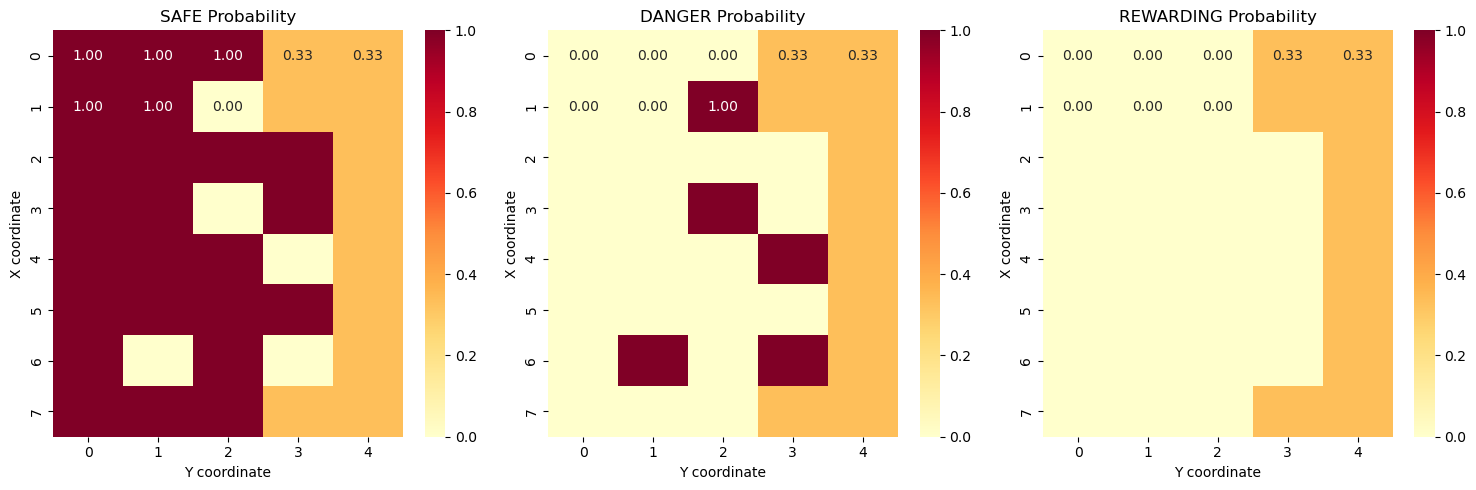

Action at time 10: UP
self.current_location: (4, 0)
0 (4, 0) (6, 4) [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (7, 1), (0, 2), (2, 2), (4, 2), (5, 2), (6, 2), (7, 2), (0, 3), (1, 3), (2, 3), (3, 3), (5, 3), (7, 3), (0, 4), (1, 4), (2, 4), (3, 4), (5, 4), (7, 4), (4, 0)] [(6, 1), (1, 2), (3, 2), (4, 3), (6, 3), (4, 4)]
Grid location at time 10: (4, 0)
Reward at time 10: 0
Observation: [20, 0]


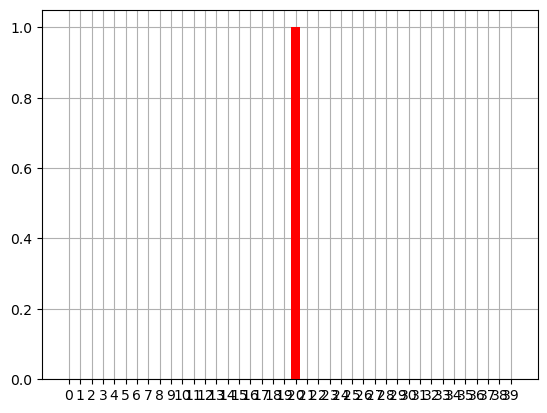

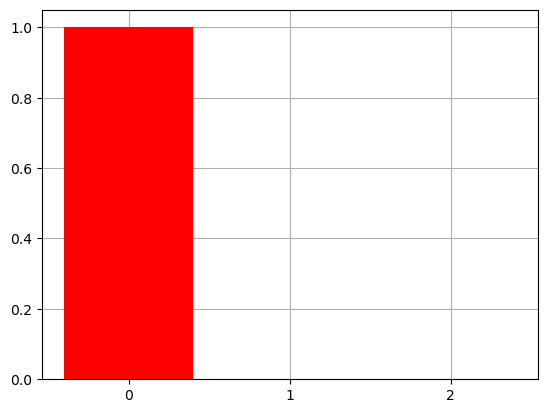

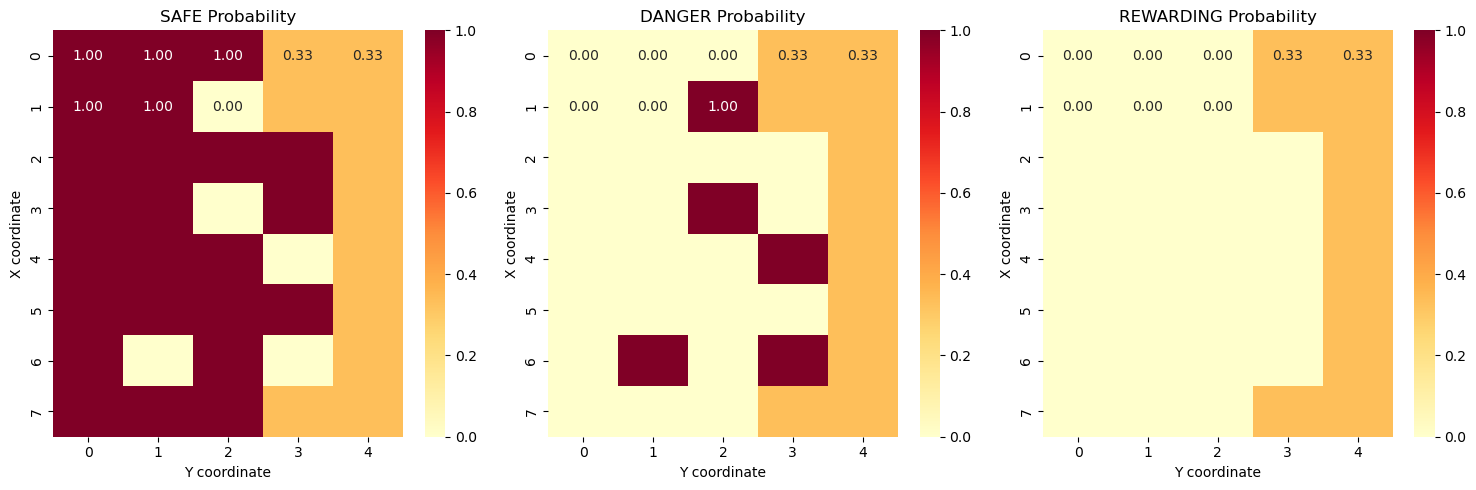

Action at time 11: UP
self.current_location: (4, 0)
0 (4, 0) (6, 4) [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (7, 1), (0, 2), (2, 2), (4, 2), (5, 2), (6, 2), (7, 2), (0, 3), (1, 3), (2, 3), (3, 3), (5, 3), (7, 3), (0, 4), (1, 4), (2, 4), (3, 4), (5, 4), (7, 4), (4, 0)] [(6, 1), (1, 2), (3, 2), (4, 3), (6, 3), (4, 4)]
Grid location at time 11: (4, 0)
Reward at time 11: 0
Observation: [20, 0]


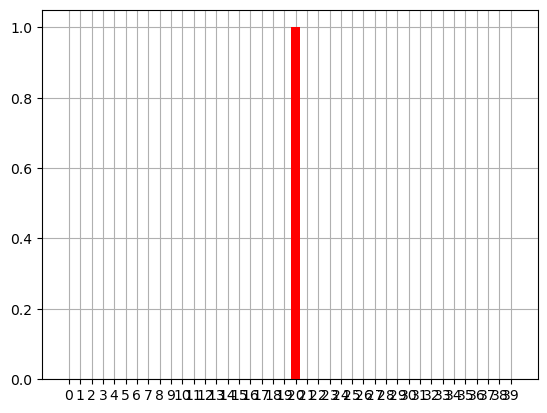

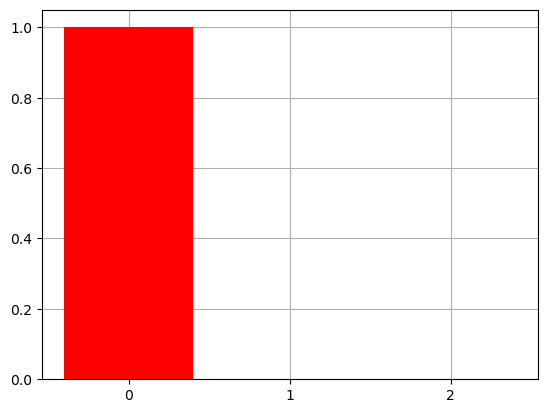

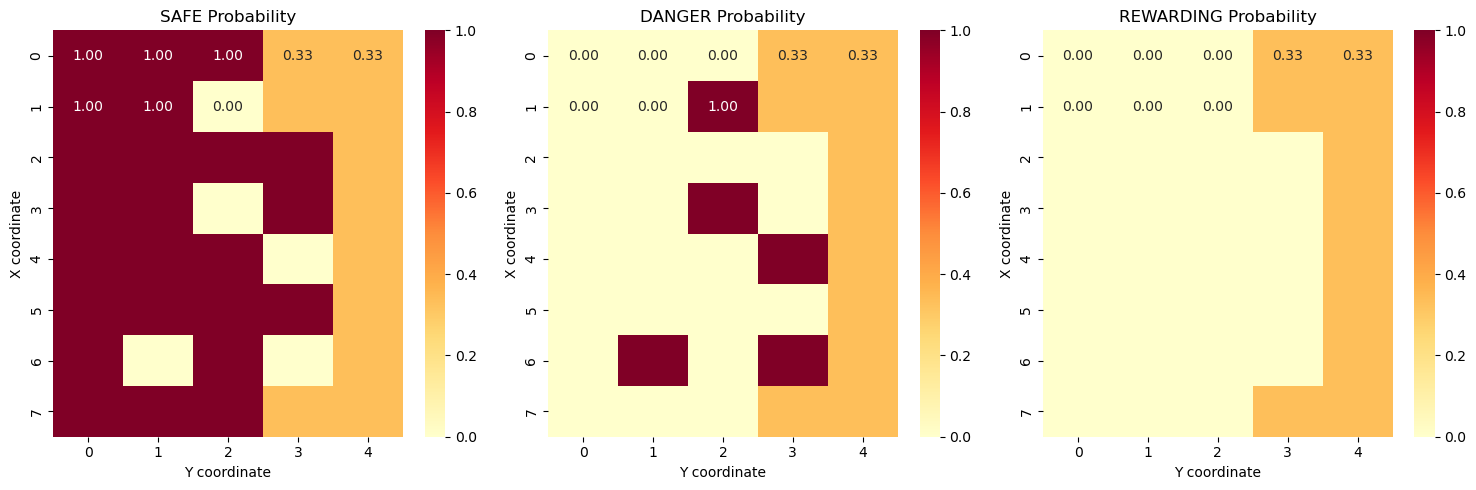

Action at time 12: UP
self.current_location: (4, 0)
0 (4, 0) (6, 4) [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (7, 1), (0, 2), (2, 2), (4, 2), (5, 2), (6, 2), (7, 2), (0, 3), (1, 3), (2, 3), (3, 3), (5, 3), (7, 3), (0, 4), (1, 4), (2, 4), (3, 4), (5, 4), (7, 4), (4, 0)] [(6, 1), (1, 2), (3, 2), (4, 3), (6, 3), (4, 4)]
Grid location at time 12: (4, 0)
Reward at time 12: 0
Observation: [20, 0]


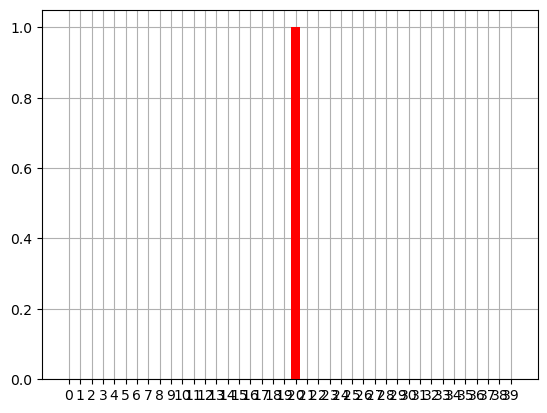

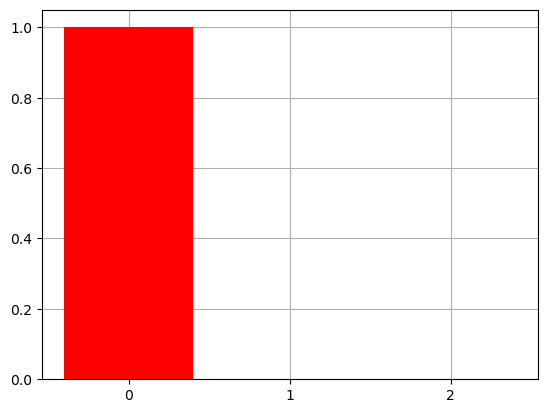

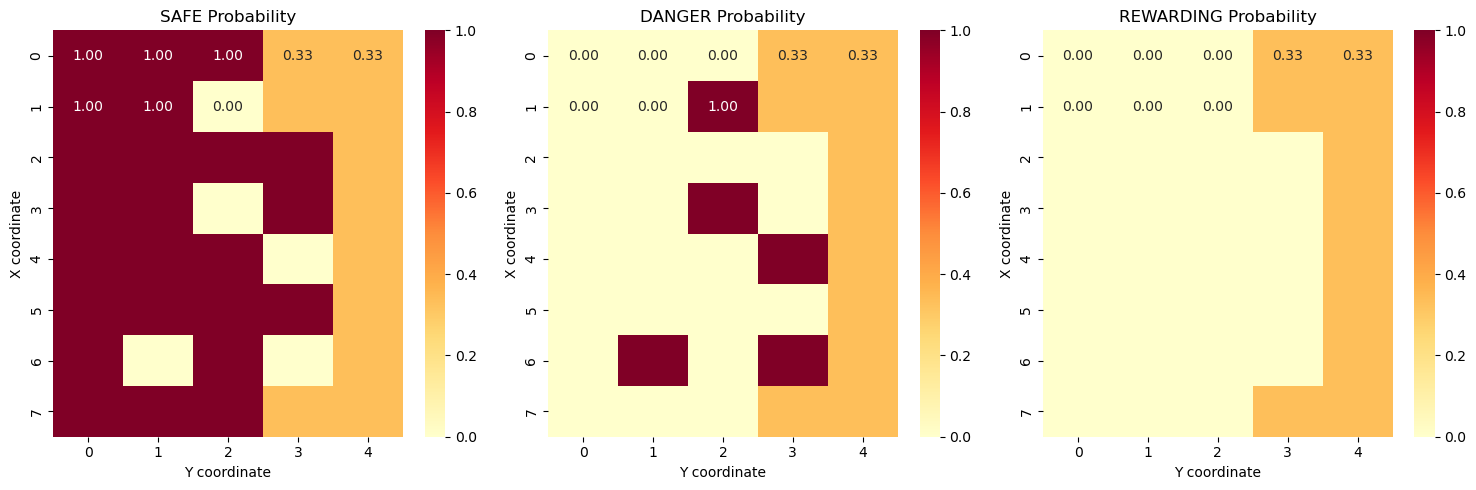

Action at time 13: UP
self.current_location: (4, 0)
0 (4, 0) (6, 4) [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (7, 1), (0, 2), (2, 2), (4, 2), (5, 2), (6, 2), (7, 2), (0, 3), (1, 3), (2, 3), (3, 3), (5, 3), (7, 3), (0, 4), (1, 4), (2, 4), (3, 4), (5, 4), (7, 4), (4, 0)] [(6, 1), (1, 2), (3, 2), (4, 3), (6, 3), (4, 4)]
Grid location at time 13: (4, 0)
Reward at time 13: 0
Observation: [20, 0]


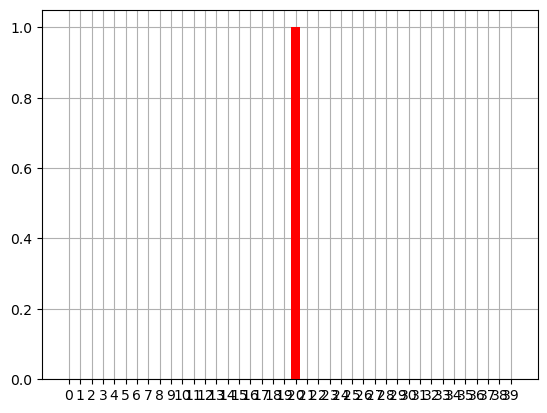

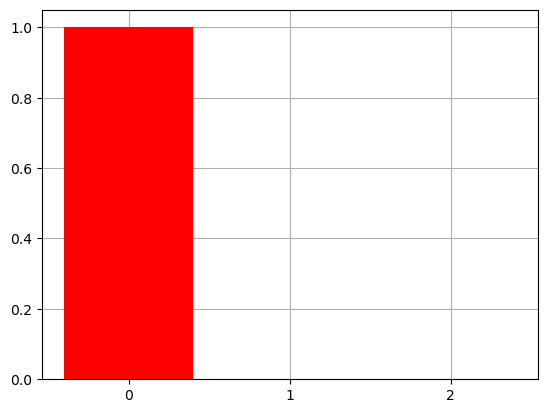

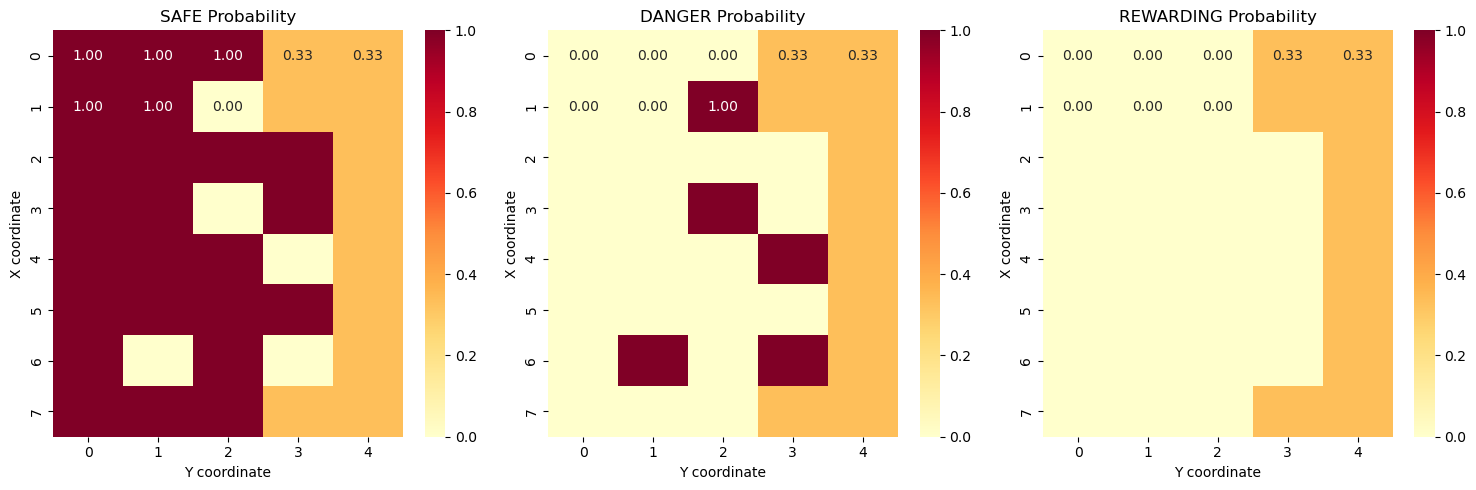

Action at time 14: UP
self.current_location: (4, 0)
0 (4, 0) (6, 4) [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (7, 1), (0, 2), (2, 2), (4, 2), (5, 2), (6, 2), (7, 2), (0, 3), (1, 3), (2, 3), (3, 3), (5, 3), (7, 3), (0, 4), (1, 4), (2, 4), (3, 4), (5, 4), (7, 4), (4, 0)] [(6, 1), (1, 2), (3, 2), (4, 3), (6, 3), (4, 4)]
Grid location at time 14: (4, 0)
Reward at time 14: 0


In [126]:
history_of_locs = [loc_obs]

T = 15

for t in range(T):
    obs = create_observation(loc_obs, red_obs, green_obs, white_obs)
    print(f"Observation: {obs}")
    obs_matrix = update_obs_matrix(obs_matrix, obs)

    # Update beliefs
    qs = my_agent.infer_states(obs)

    plot_beliefs(qs[0])
    plot_beliefs(qs[1])
    
    # Update obs matrix
    surrounding_locs = update_vision(loc_obs, grid_dims, 2)
    for loc in surrounding_locs:
        obs = create_observation(loc, red_obs, green_obs, white_obs)
        obs_matrix = update_obs_matrix(obs_matrix, obs)
        
    visualize_obs_matrix(obs_matrix, grid_dims)
    
    # Policy selection
    my_agent.infer_policies()
    chosen_action_id = my_agent.sample_action()
    
    movement_id = int(chosen_action_id[0])
    choice_action = actions[movement_id]
    print(f'Action at time {t}: {choice_action}')
    
    # Environment step
    loc_obs, green_obs, white_obs, red_obs, agent_reward = my_env.step(choice_action)
    
    print(agent_reward, loc_obs, green_obs, white_obs, red_obs)
    history_of_locs.append(loc_obs)
    print(f'Grid location at time {t}: {loc_obs}')
    print(f'Reward at time {t}: {agent_reward}')